By `Roboflow`: @https://github.com/roboflow/notebooks/blob/main/notebooks/football-ai.ipynb

In [18]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/
!pip install -q git+https://github.com/roboflow/sports.git
!pip uninstall -y supervision
!pip install -q supervision>=0.23.0
!pip install -q roboflow


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-gpu 0.21.1 requires onnxruntime-gpu<=1.15.1, but you have onnxruntime-gpu 1.18.0 which is incompatible.
Found existing installation: supervision 0.22.0
Uninstalling supervision-0.22.0:
  Successfully uninstalled supervision-0.22.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-gpu 0.21.1 requires onnxruntime-gpu<=1.15.1, but you have onnxruntime-gpu 1.18.0 which is incompatible.
inference-gpu 0.21.1 requires supervision<=0.22.0,>=0.21.0, but you have supervision 0.23.0 which is incompatible.


**Note:** Let's try few sample videos from `DFL-Bundesliga

In [19]:
!gdown -O "0bfacc_0.mp4" "https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF"

Downloading...
From: https://drive.google.com/uc?id=12TqauVZ9tLAv8kWxTTBFWtgt2hNQ4_ZF
To: /kaggle/working/0bfacc_0.mp4
100%|███████████████████████████████████████| 19.9M/19.9M [00:00<00:00, 112MB/s]


## |**`Model Detection`**|
**Note:** this is a trained model for ball, player, goalkeeper and referee detection

In [20]:
from inference import get_model
import supervision as sv

PLAYER_DETECTION_MODEL = get_model(model_id="football-players-detection-3zvbc/11", api_key="4LkXLK8ZSbLkfVFlFbMf")


> # Visualization

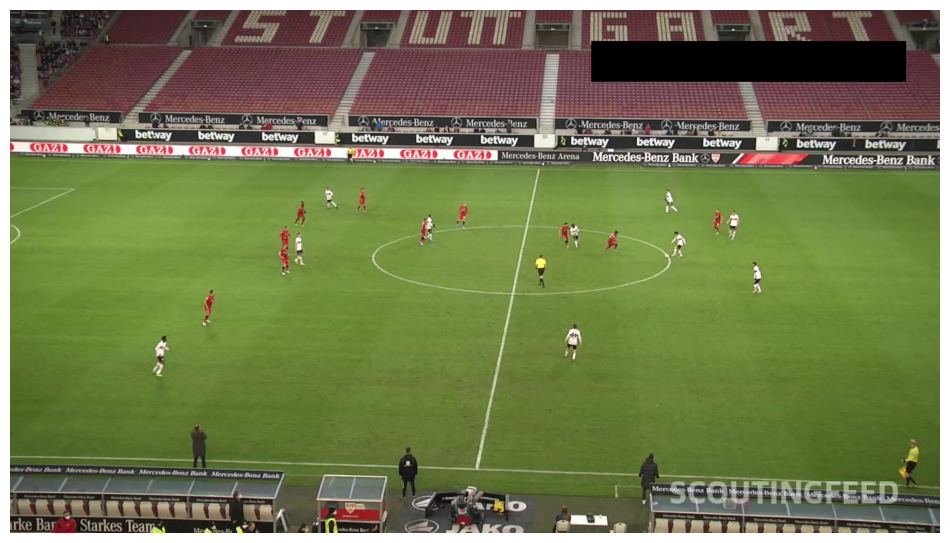

In [21]:
SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)
sv.plot_image(frame)

## |**`Detection`**|

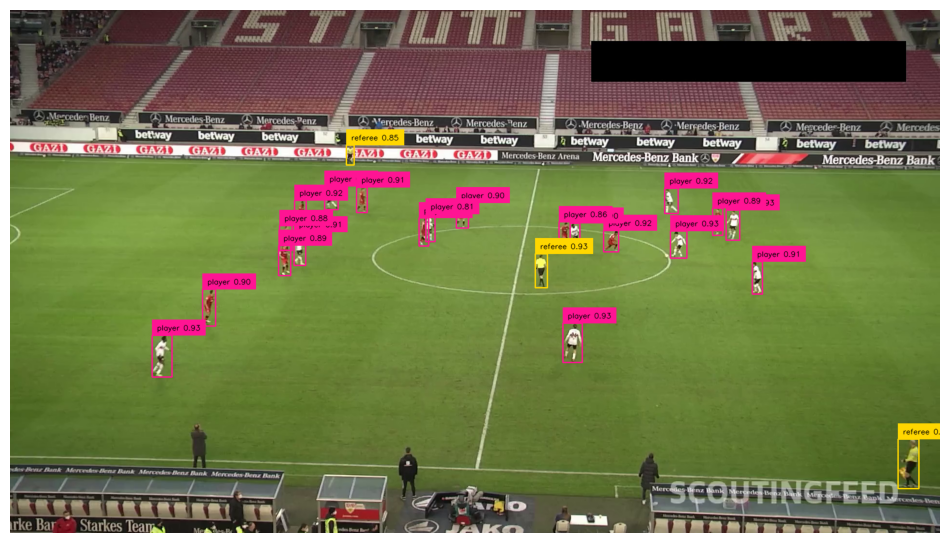

In [22]:
import supervision as sv

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(["#FF0000", "#00BFFF", "#FF1493", "#FFD700"]),
    thickness=2,
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(["#FF0000", "#00BFFF", "#FF1493", "#FFD700"]),
    text_color=sv.Color.from_hex("#000000"),
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

labels = [
    f"{class_name} {confidence:0.2f}"
    for class_name, confidence in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

sv.plot_image(annotated_frame)


## |**`Video Game`**|

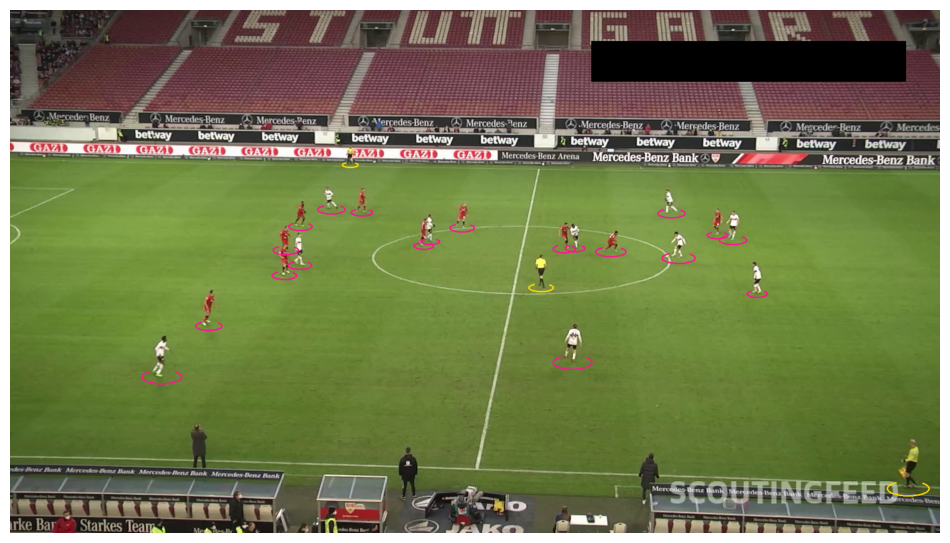

In [23]:
import supervision as sv

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## |**`Tracking`**|

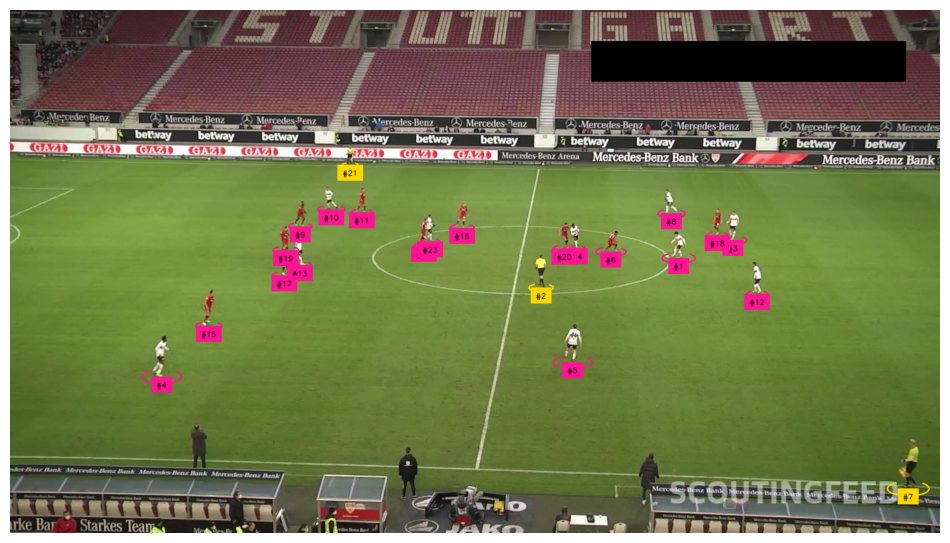

In [24]:
import supervision as sv

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

> # Team Splitter

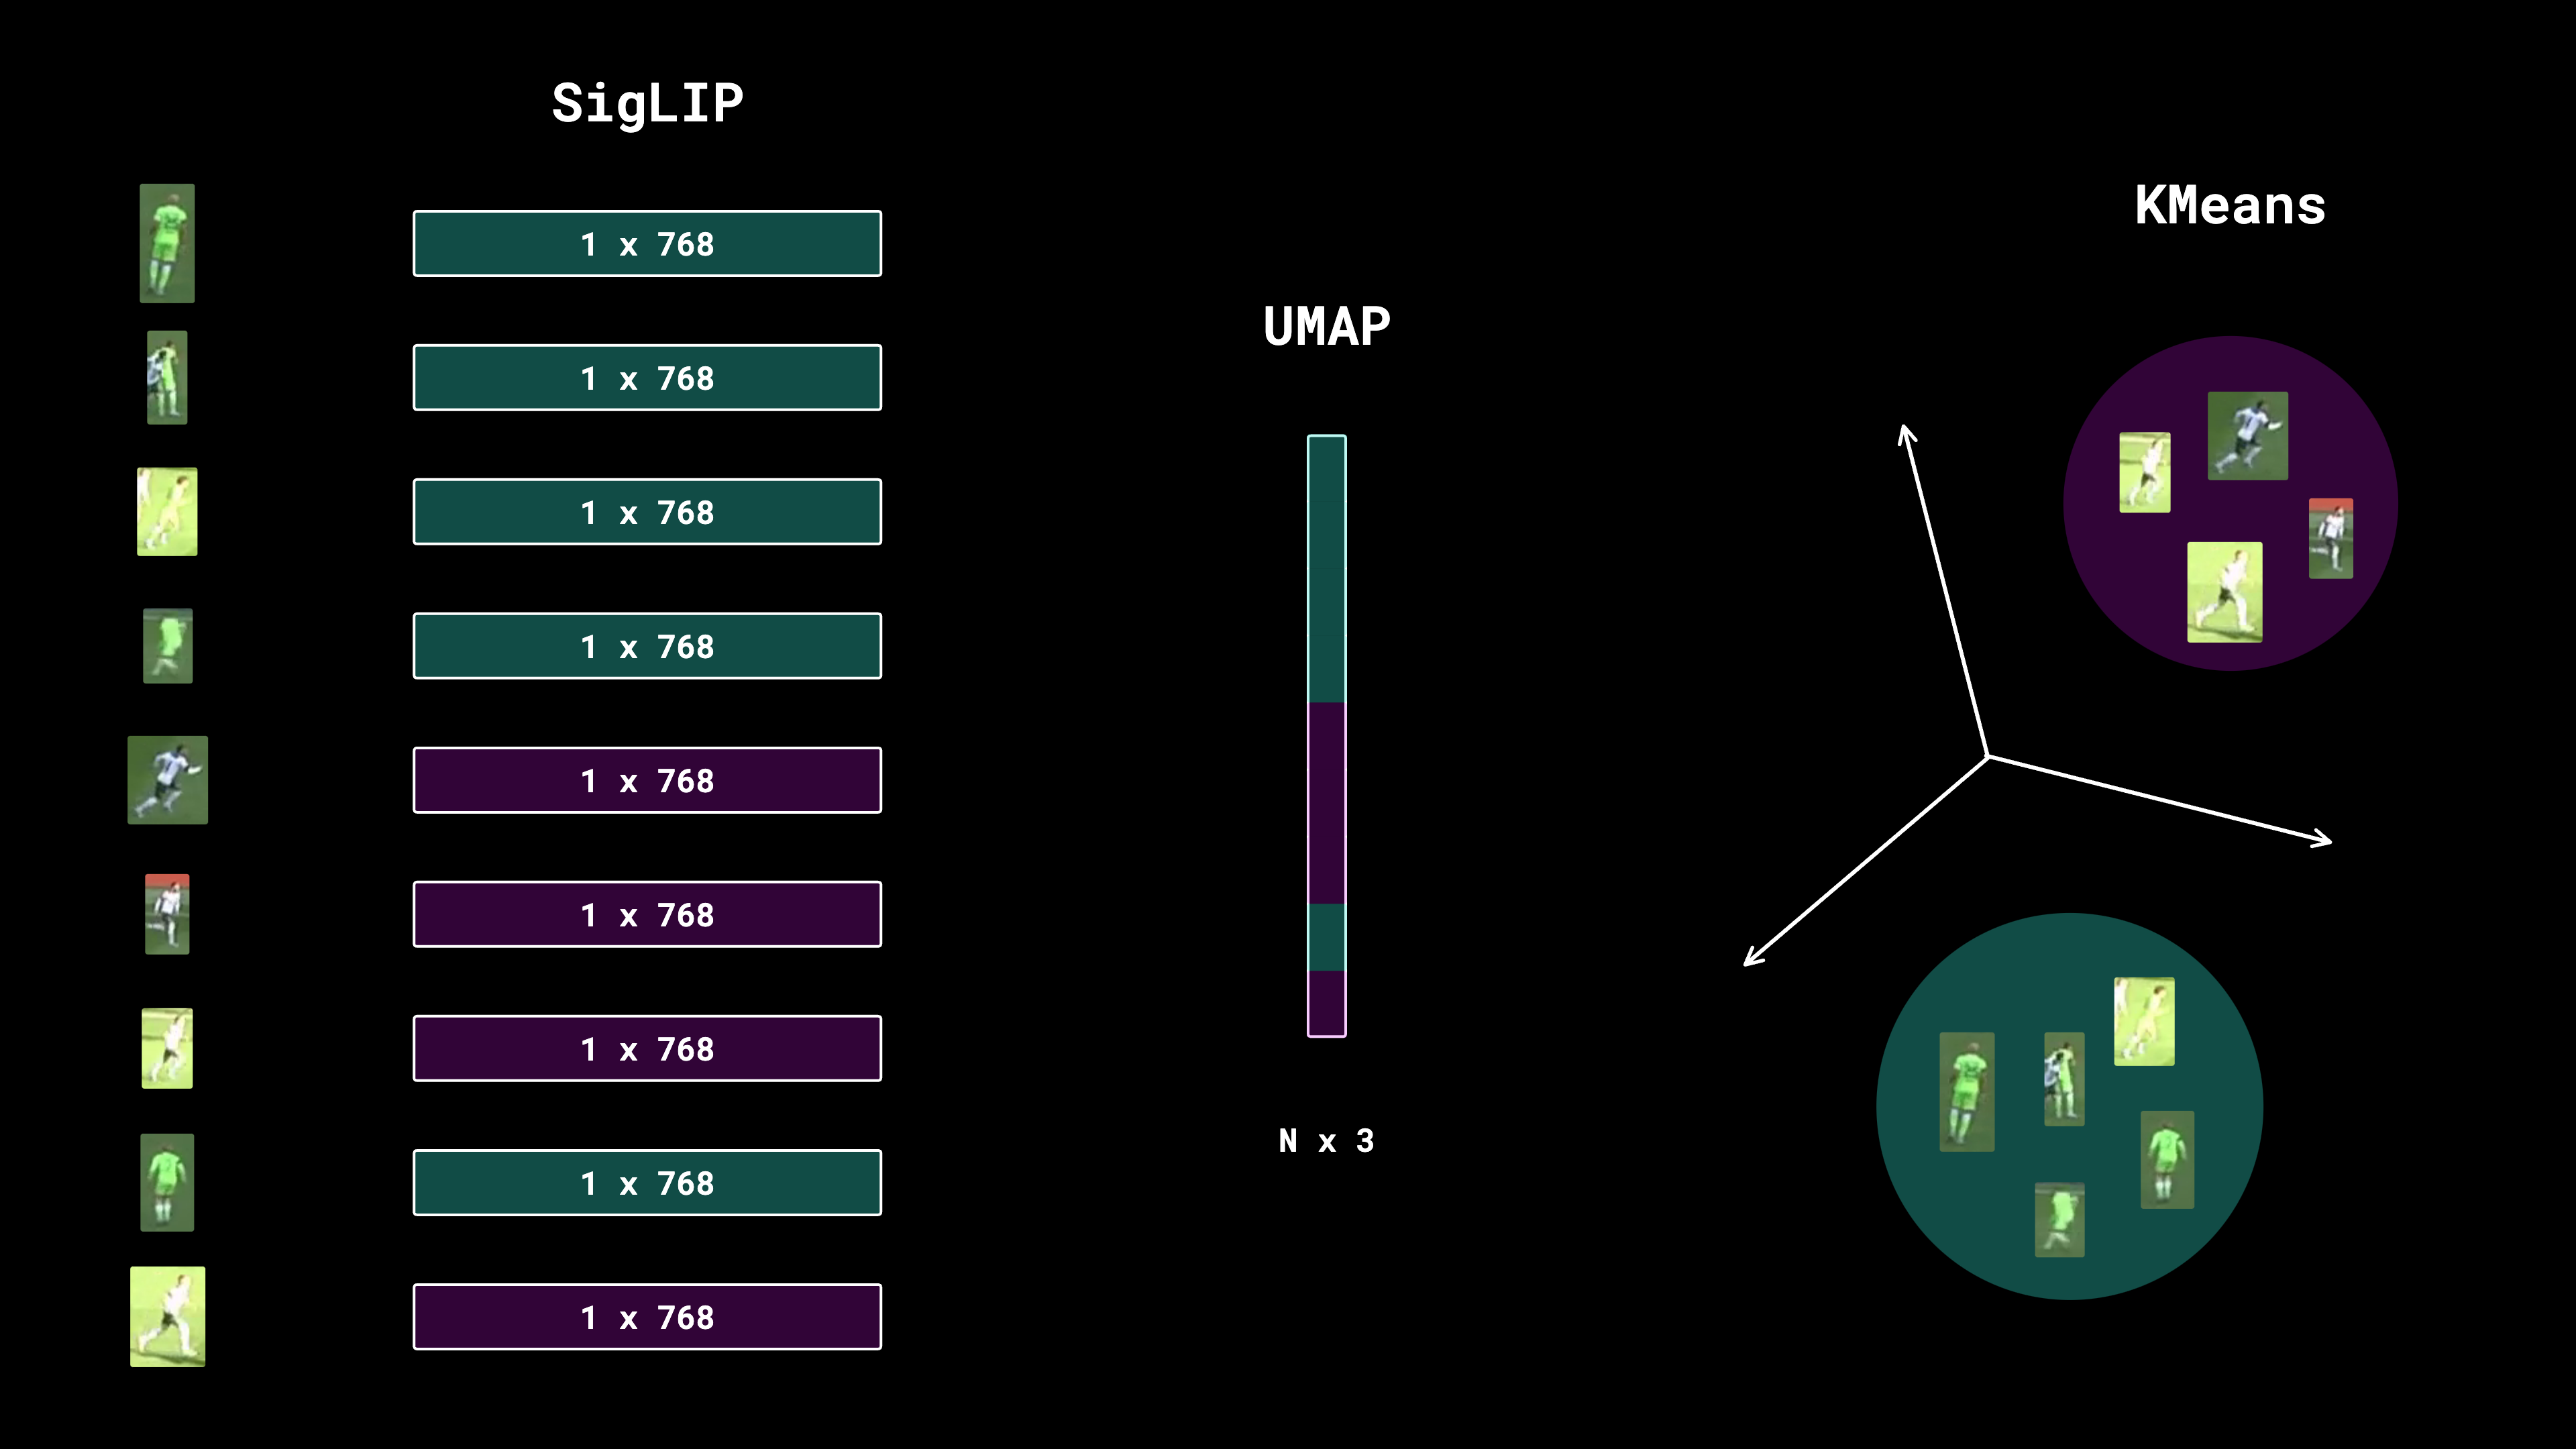
**Note:** Before training our player clustering model, we need to gather training data. To do this, we'll sample one frame per second, detect players within those frames, and then crop them out.

In [25]:
from tqdm import tqdm

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    detections = detections.with_nms(threshold=0.5, class_agnostic=True)
    detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

collecting crops: 25it [00:10,  2.47it/s]


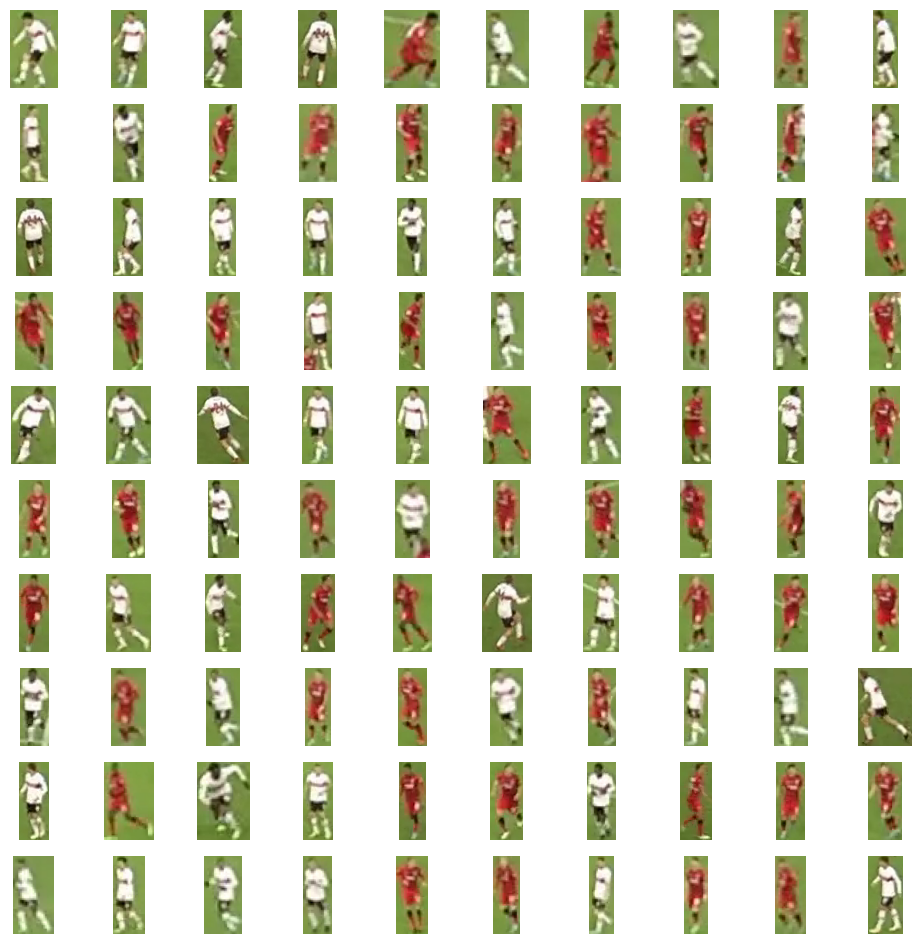

In [26]:
sv.plot_images_grid(crops[:100], grid_size=(10, 10))

**Note:** Next, we'll run SigLIP to calculate embeddings for each of the crops.

In [27]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = 'google/siglip-base-patch16-224'

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH)


config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

In [28]:
import numpy as np
from more_itertools import chunked

BATCH_SIZE = 32
crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []
with torch.no_grad():
    for batch in tqdm(batches, desc='embedding extraction'):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

embedding extraction: 16it [00:07,  2.24it/s]


**Note:** Using UMAP, we project our embeddings from `(N, 768)` to `(N, 3)` and then perform a two cluster division using KMeans

In [29]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [30]:
projections = REDUCER.fit_transform(data)
clusters = CLUSTERING_MODEL.fit_predict(projections)

## |**`PLOTS`**|

In [31]:
!pip install plotly

In [32]:
import plotly.graph_objects as go
import numpy as np
from typing import Dict, List
from IPython.display import display, HTML
from PIL import Image
import base64
from io import BytesIO

def pil_image_to_data_uri(image: Image.Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_str}"

def display_projections(
    labels: np.ndarray,
    projections: np.ndarray,
    images: List[Image.Image],
    show_legend: bool = False,
    show_markers_with_text: bool = True
) -> None:
    image_data_uris = {f"image_{i}": pil_image_to_data_uri(image) for i, image in enumerate(images)}
    image_ids = np.array([f"image_{i}" for i in range(len(images))])

    unique_labels = np.unique(labels)
    traces = []
    for unique_label in unique_labels:
        mask = labels == unique_label
        customdata_masked = image_ids[mask]
        trace = go.Scatter3d(
            x=projections[mask][:, 0],
            y=projections[mask][:, 1],
            z=projections[mask][:, 2],
            mode='markers+text' if show_markers_with_text else 'markers',
            text=labels[mask],
            customdata=customdata_masked,
            name=str(unique_label),
            marker=dict(size=8),
            hovertemplate="class: %{text}<br>image ID: %{customdata}<extra></extra>"
        )
        traces.append(trace)

    fig = go.Figure(data=traces)
    fig.update_layout(
        scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
        width=1000,
        height=1000,
        showlegend=show_legend
    )

    plotly_div = fig.to_html(full_html=False, include_plotlyjs='cdn', div_id="scatter-plot-3d")

    javascript_code = f"""
    <script>
        document.getElementById('scatter-plot-3d').on('plotly_hover', function(data) {{
            var point = data.points[0];
            var imageId = point.customdata;
            var imageDataUri = '{'{' + 'image_data_uris[imageId]' + '}'}';
            var imgElement = document.createElement('img');
            imgElement.src = imageDataUri;
            imgElement.style.position = 'absolute';
            imgElement.style.left = point.xaxis.d2p(point.x) + 'px';
            imgElement.style.top = point.yaxis.d2p(point.y) + 'px';
            imgElement.style.zIndex = 1000;
            document.body.appendChild(imgElement);
        }});
    </script>
    """

    html_template = f"""
    <div>
        <h3>Click on a data entry to display an image</h3>
        {plotly_div}
        {javascript_code}
    </div>
    """

    display(HTML(html_template))
    
display_projections(clusters, projections, crops)


> # Team Classifier

**Note:** To simplify the use of the SigLIP, UMAP, and KMeans combo, I've packaged all these models into a `TeamClassifier` that you can find in the sports repository.

In [33]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(
    source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:10,  2.40it/s]
Embedding extraction: 19it [00:07,  2.44it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



**Note:** Time to assign goalkeepers to teams. We'll use a simple heuristic: calculate the average position (centroid) of the players belonging to both teams and then assign the `goalkeeper` to the team whose average position is closer.

In [34]:
import numpy as np
import supervision as sv

def resolve_goalkeepers_team_id(
    players: sv.Detections,
    goalkeepers: sv.Detections
) -> np.ndarray:
    goalkeepers_xy = goalkeepers.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    players_xy = players.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    team_0_centroid = players_xy[players.class_id == 0].mean(axis=0)
    team_1_centroid = players_xy[players.class_id == 1].mean(axis=0)
    goalkeepers_team_id = []
    for goalkeeper_xy in goalkeepers_xy:
        dist_0 = np.linalg.norm(goalkeeper_xy - team_0_centroid)
        dist_1 = np.linalg.norm(goalkeeper_xy - team_1_centroid)
        goalkeepers_team_id.append(0 if dist_0 < dist_1 else 1)

    return np.array(goalkeepers_team_id)

Embedding extraction: 1it [00:00,  3.78it/s]


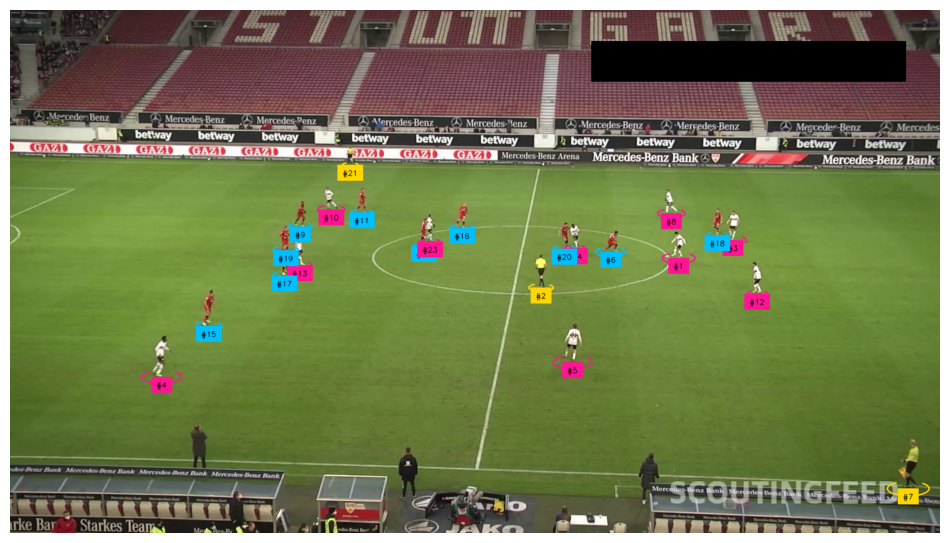

In [35]:
import supervision as sv

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

## |**`Keypoints`**|

In [36]:
from inference import get_model

ROBOFLOW_API_KEY = '4LkXLK8ZSbLkfVFlFbMf'
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

/opt/conda/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning:

Specified provider 'OpenVINOExecutionProvider' is not in available provider names.Available providers: 'TensorrtExecutionProvider, CUDAExecutionProvider, CPUExecutionProvider'



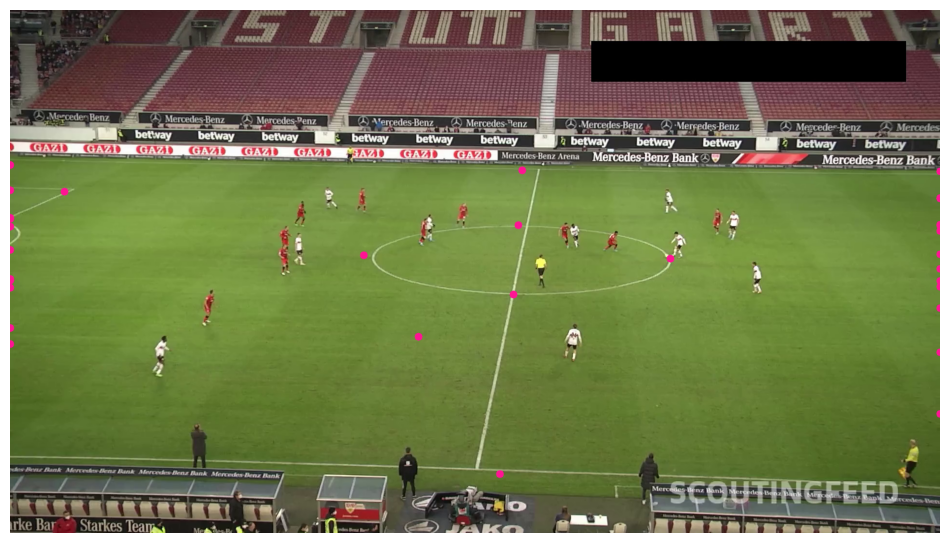

In [37]:
import supervision as sv

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

**Note:** Notice that some of the keypoints we detected are in incorrect locations. These are keypoints with a low confidence level. so we will filter low confidence keypoint to get rid of it.

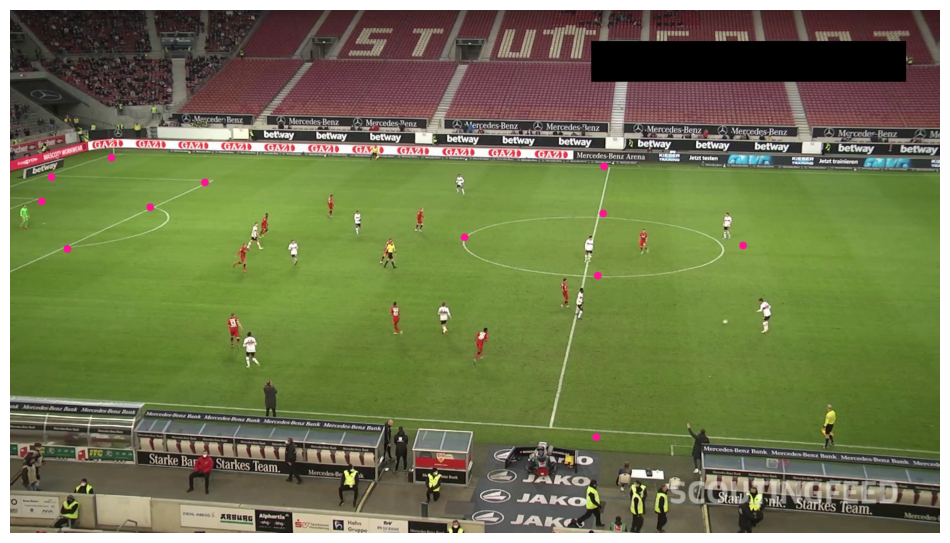

In [38]:
import supervision as sv

SOURCE_VIDEO_PATH = '/kaggle/working/0bfacc_0.mp4'

Vertex_annotator = sv.VertexAnnotator(
    color = sv.Color.from_hex("#FF1493"),
    radius=8,
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...]
)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

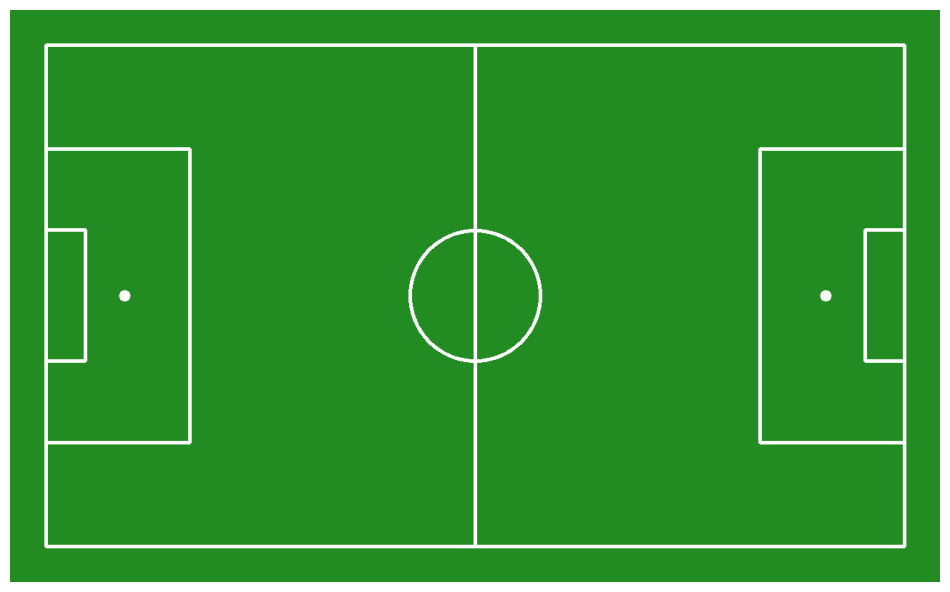

In [39]:
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

annotated_frame = draw_pitch(CONFIG)

sv.plot_image(annotated_frame)

**Note:** It's time to utilize the keypoint pairs located on the camera perspective plane and the football pitch plane. The sports repository includes a ViewTransformer, which employs homography for perspective transformation.

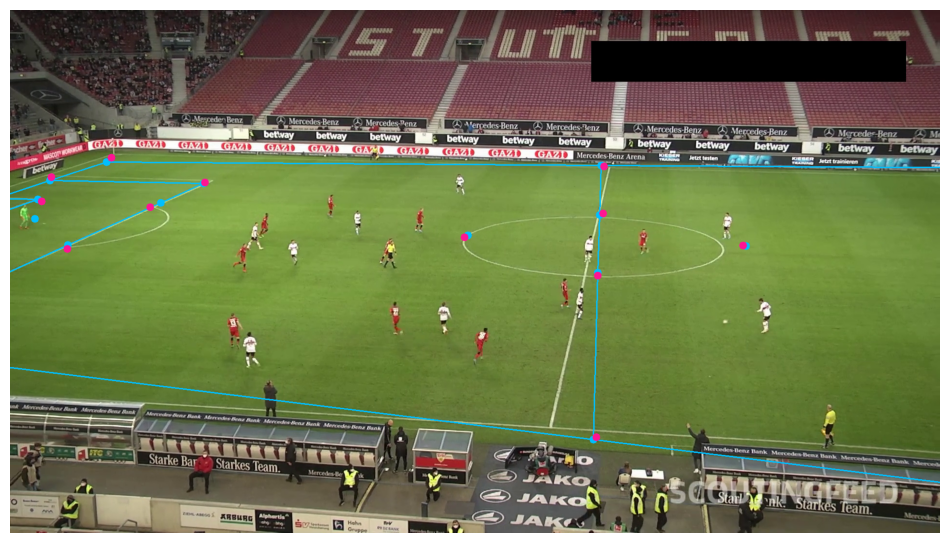

In [40]:
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

> ## Project ball, players and referies on pitch

In [41]:
import supervision as sv
from tqdm import tqdm
from sports.common.team import TeamClassifier

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
PLAYER_ID = 2
STRIDE = 30

frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH, stride=STRIDE)

crops = []
for frame in tqdm(frame_generator, desc='collecting crops'):
    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)
    players_detections = detections[detections.class_id == PLAYER_ID]
    players_crops = [sv.crop_image(frame, xyxy) for xyxy in detections.xyxy]
    crops += players_crops

team_classifier = TeamClassifier(device="cuda")
team_classifier.fit(crops)

collecting crops: 25it [00:10,  2.43it/s]
Embedding extraction: 19it [00:07,  2.47it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [42]:
import cv2
from typing import Optional

def draw_pitch_voronoi_diagram_2(
    config: SoccerPitchConfiguration,
    team_1_xy: np.ndarray,
    team_2_xy: np.ndarray,
    team_1_color: sv.Color = sv.Color.RED,
    team_2_color: sv.Color = sv.Color.WHITE,
    opacity: float = 0.5,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None
) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    scaled_width = int(config.width * scale)
    scaled_length = int(config.length * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((
        scaled_width + 2 * padding,
        scaled_length + 2 * padding
    ))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                       (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

Embedding extraction: 1it [00:00,  3.87it/s]


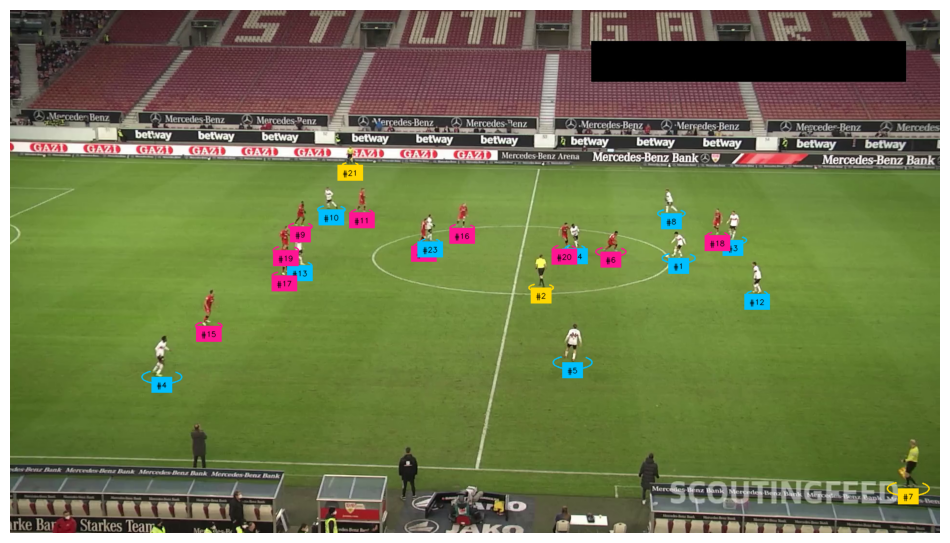

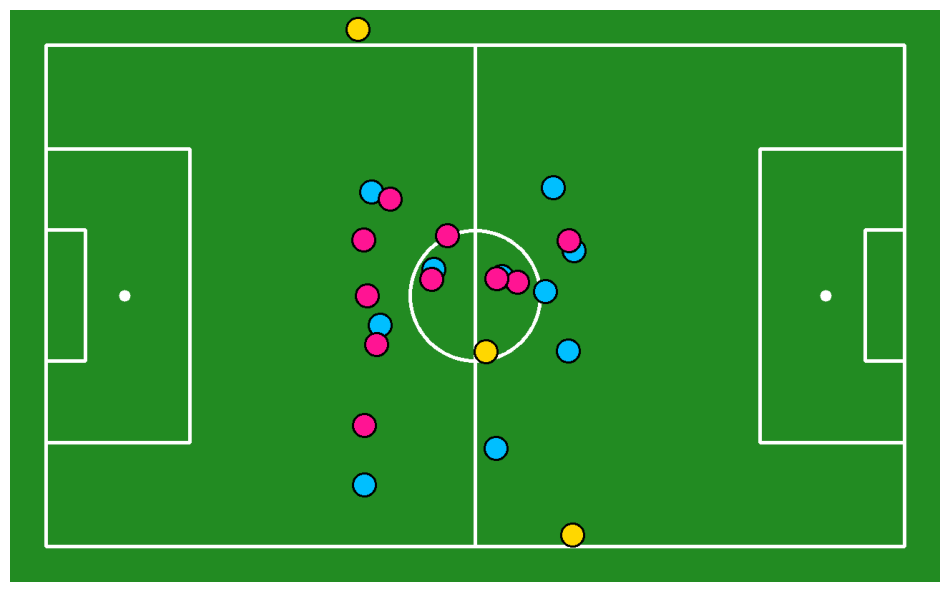

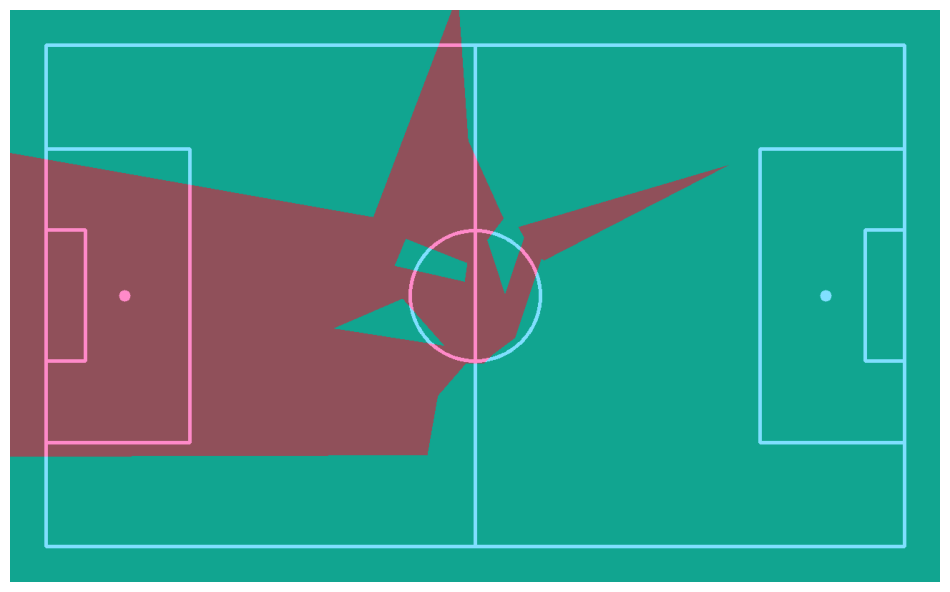

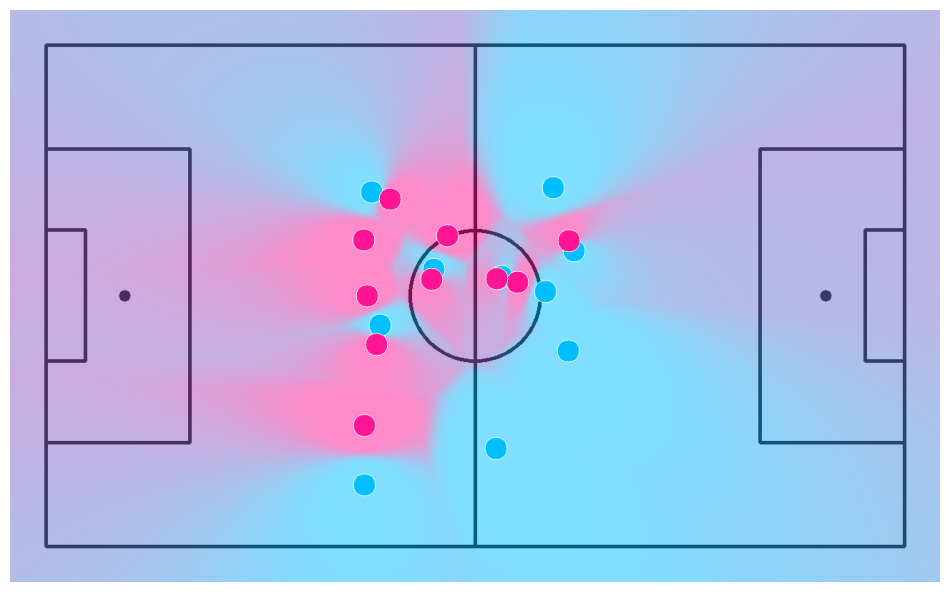

In [43]:
import supervision as sv
from sports.annotators.soccer import (
    draw_pitch,
    draw_points_on_pitch,
    draw_pitch_voronoi_diagram
)

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

# ball, goalkeeper, player, referee detection

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections = tracker.update_with_detections(detections=all_detections)

goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
players_detections = all_detections[all_detections.class_id == PLAYER_ID]
referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

# team assignment

players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
players_detections.class_id = team_classifier.predict(players_crops)

goalkeepers_detections.class_id = resolve_goalkeepers_team_id(
    players_detections, goalkeepers_detections)

referees_detections.class_id -= 1

all_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections, referees_detections])

# frame visualization

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

all_detections.class_id = all_detections.class_id.astype(int)

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)

players_detections = sv.Detections.merge([
    players_detections, goalkeepers_detections
])

# detect pitch key points
result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

# project ball, players and referies on pitch
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

players_xy = players_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_players_xy = transformer.transform_points(points=players_xy)

referees_xy = referees_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_referees_xy = transformer.transform_points(points=referees_xy)

# visualize video game-style radar view

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_referees_xy,
    face_color=sv.Color.from_hex('FFD700'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_pitch_voronoi_diagram(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

# visualize voronoi diagram with blend

annotated_frame = draw_pitch(
    config=CONFIG,
    background_color=sv.Color.WHITE,
    line_color=sv.Color.BLACK
)
annotated_frame = draw_pitch_voronoi_diagram_2(
    config=CONFIG,
    team_1_xy=pitch_players_xy[players_detections.class_id == 0],
    team_2_xy=pitch_players_xy[players_detections.class_id == 1],
    team_1_color=sv.Color.from_hex('00BFFF'),
    team_2_color=sv.Color.from_hex('FF1493'),
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.WHITE,
    radius=8,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 0],
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_players_xy[players_detections.class_id == 1],
    face_color=sv.Color.from_hex('FF1493'),
    edge_color=sv.Color.WHITE,
    radius=16,
    thickness=1,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

> # **Ball Tracker**

In [44]:
from collections import deque
import supervision as sv
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOURCE_VIDEO_PATH = "/kaggle/working/0bfacc_0.mp4"
BALL_ID = 0
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    path_raw.append(pitch_ball_xy)

100%|██████████| 750/750 [04:11<00:00,  2.98it/s]


In [47]:
path = [
    np.empty((0,2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates for coorinates in path_raw
]
path = [coorinates.flatten() for coorinates in path]

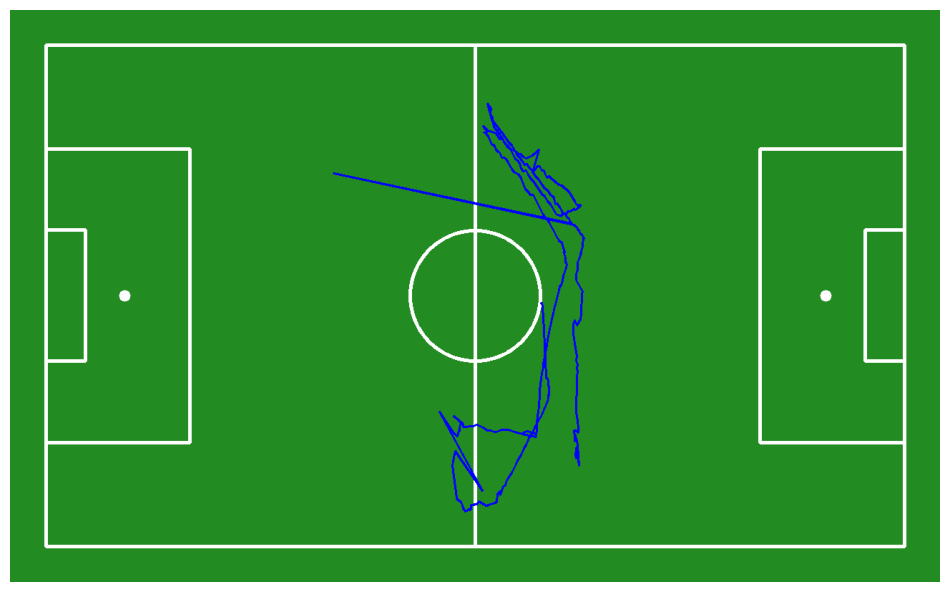

In [49]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.BLUE,
    pitch=annotated_frame
)

sv.plot_image(annotated_frame)

In [50]:
from typing import List, Union

def replace_outliers_based_on_distance(
    positions: List[np.ndarray],
    distance_threshold: float
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            # If the current position is already empty, just add it to the cleaned positions
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                # If there's no valid last position, accept the first valid one
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                # Calculate the distance from the last valid position
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    # Replace with empty array if the distance exceeds the threshold
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position

    return cleaned_positions

In [52]:
MAX_DISTANCE_THROD = 500
path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THROD)


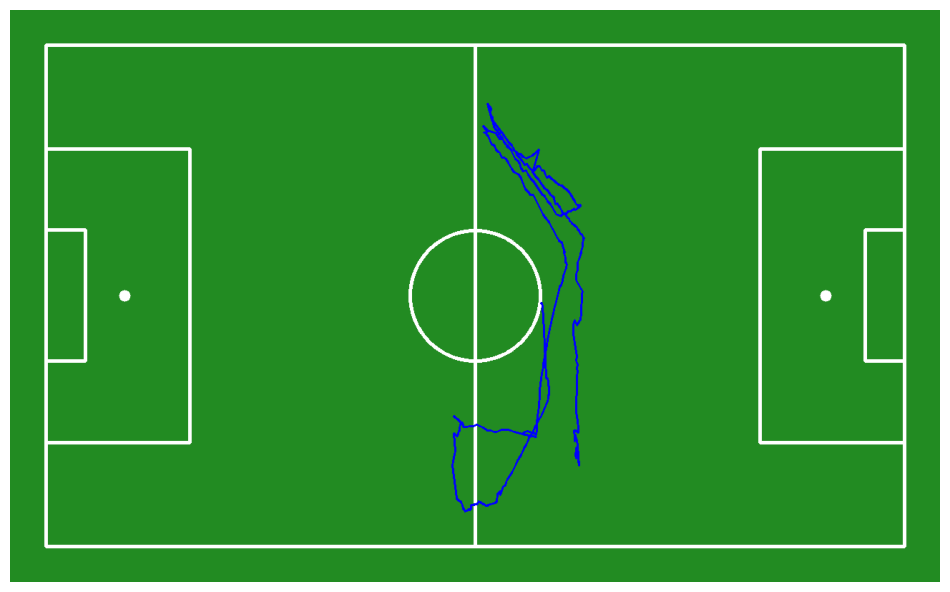

In [53]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.BLUE,
    pitch=annotated_frame,
)

sv.plot_image(annotated_frame)